Loading California Housing dataset...
Dataset shape: (20640, 8)
Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']

Dataset info:
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude        target  
count  20640.000000  20640.000000  2

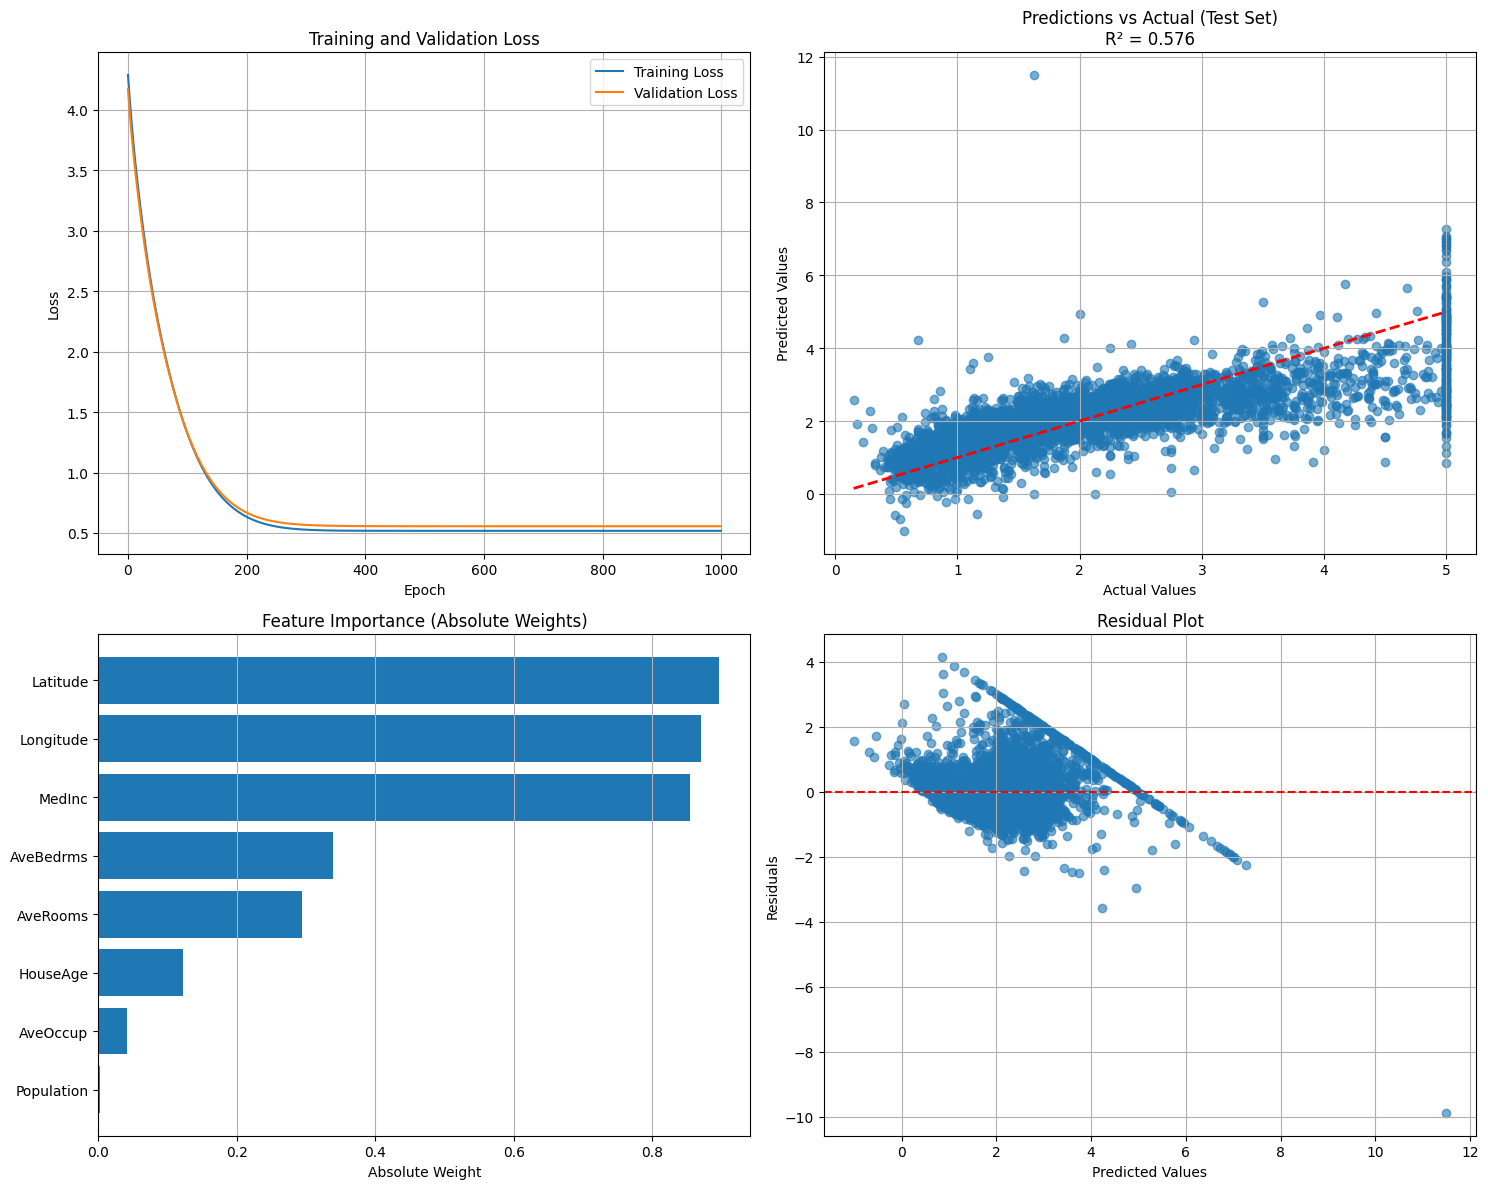


Top 3 most important features:
Latitude: -0.8969
Longitude: -0.8698
MedInc: 0.8544

Sample Predictions:
Sample 1 - Actual: $2.3800k, Predicted: $1.9600k
Sample 2 - Actual: $3.3000k, Predicted: $2.6700k
Sample 3 - Actual: $0.9500k, Predicted: $1.9500k
Sample 4 - Actual: $2.4500k, Predicted: $2.5300k
Sample 5 - Actual: $0.6400k, Predicted: $0.0500k


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

class LinearRegressionModel(nn.Module):
    def __init__(self, input_size):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)
    
    def forward(self, x):
        return self.linear(x)

# Load California Housing dataset
print("Loading California Housing dataset...")
data = fetch_california_housing()
X, y = data.data, data.target

# Create DataFrame for better visualization
feature_names = data.feature_names
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

print(f"Dataset shape: {X.shape}")
print(f"Features: {feature_names}")
print("\nDataset info:")
print(df.describe())

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test).reshape(-1, 1)

print(f"\nTraining set size: {X_train_tensor.shape[0]}")
print(f"Test set size: {X_test_tensor.shape[0]}")

# Create model
input_size = X_train_tensor.shape[1]
model = LinearRegressionModel(input_size)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training
num_epochs = 1000
train_losses = []
val_losses = []

print("\nTraining started...")
for epoch in range(num_epochs):
    # Training
    model.train()
    train_pred = model(X_train_tensor)
    train_loss = criterion(train_pred, y_train_tensor)
    
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_pred = model(X_test_tensor)
        val_loss = criterion(val_pred, y_test_tensor)
    
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

# Final evaluation
model.eval()
with torch.no_grad():
    train_pred = model(X_train_tensor).numpy()
    test_pred = model(X_test_tensor).numpy()

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
train_r2 = r2_score(y_train, train_pred)
test_r2 = r2_score(y_test, test_pred)

print(f"\nFinal Results:")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Train R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")

# Feature importance (coefficients)
weights = model.linear.weight.detach().numpy().flatten()
bias = model.linear.bias.detach().numpy()[0]

print(f"\nModel Parameters:")
print(f"Bias: {bias:.4f}")
print("\nFeature Weights (importance):")
for feature, weight in zip(feature_names, weights):
    print(f"{feature}: {weight:.4f}")

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Training and validation loss
axes[0, 0].plot(train_losses, label='Training Loss')
axes[0, 0].plot(val_losses, label='Validation Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot 2: Predictions vs Actual (Test set)
axes[0, 1].scatter(y_test, test_pred, alpha=0.6)
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual Values')
axes[0, 1].set_ylabel('Predicted Values')
axes[0, 1].set_title(f'Predictions vs Actual (Test Set)\nR² = {test_r2:.3f}')
axes[0, 1].grid(True)

# Plot 3: Feature importance
feature_importance = np.abs(weights)
sorted_idx = np.argsort(feature_importance)
axes[1, 0].barh(range(len(feature_importance)), feature_importance[sorted_idx])
axes[1, 0].set_yticks(range(len(feature_importance)))
axes[1, 0].set_yticklabels([feature_names[i] for i in sorted_idx])
axes[1, 0].set_xlabel('Absolute Weight')
axes[1, 0].set_title('Feature Importance (Absolute Weights)')
axes[1, 0].grid(True, axis='x')

# Plot 4: Residuals
residuals = y_test - test_pred.flatten()
axes[1, 1].scatter(test_pred, residuals, alpha=0.6)
axes[1, 1].axhline(y=0, color='r', linestyle='--')
axes[1, 1].set_xlabel('Predicted Values')
axes[1, 1].set_ylabel('Residuals')
axes[1, 1].set_title('Residual Plot')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Display correlation matrix for top features
print(f"\nTop 3 most important features:")
top_features_idx = np.argsort(np.abs(weights))[-3:]
for idx in reversed(top_features_idx):
    print(f"{feature_names[idx]}: {weights[idx]:.4f}")

# Make predictions on a few sample points
print(f"\nSample Predictions:")
sample_indices = np.random.choice(len(X_test), 5, replace=False)
with torch.no_grad():
    for i, idx in enumerate(sample_indices):
        actual = y_test[idx]
        predicted = model(X_test_tensor[idx:idx+1]).item()
        print(f"Sample {i+1} - Actual: ${actual:.2f}00k, Predicted: ${predicted:.2f}00k")

Loading California Housing dataset...
Dataset shape: (20640, 8)
Target range: $0.100k - $5.000k

Training SimpleLinearModel...
Epoch [100/1000], Train Loss: 0.5251, Val Loss: 0.5432, LR: 0.010000
Epoch [200/1000], Train Loss: 0.5199, Val Loss: 0.5754, LR: 0.005000
Epoch [300/1000], Train Loss: 0.5185, Val Loss: 0.5562, LR: 0.001250
Epoch [400/1000], Train Loss: 0.5181, Val Loss: 0.5558, LR: 0.000313
Epoch [500/1000], Train Loss: 0.5180, Val Loss: 0.5559, LR: 0.000078
Epoch [600/1000], Train Loss: 0.5179, Val Loss: 0.5559, LR: 0.000020
Epoch [700/1000], Train Loss: 0.5179, Val Loss: 0.5559, LR: 0.000005
Epoch [800/1000], Train Loss: 0.5179, Val Loss: 0.5559, LR: 0.000001
Epoch [900/1000], Train Loss: 0.5179, Val Loss: 0.5559, LR: 0.000000
Epoch [1000/1000], Train Loss: 0.5179, Val Loss: 0.5559, LR: 0.000000
Training completed in 57.41 seconds

Training DeepRegressionModel...
Epoch [100/1000], Train Loss: 0.3508, Val Loss: 0.3154, LR: 0.001000
Epoch [200/1000], Train Loss: 0.3127, Val Lo

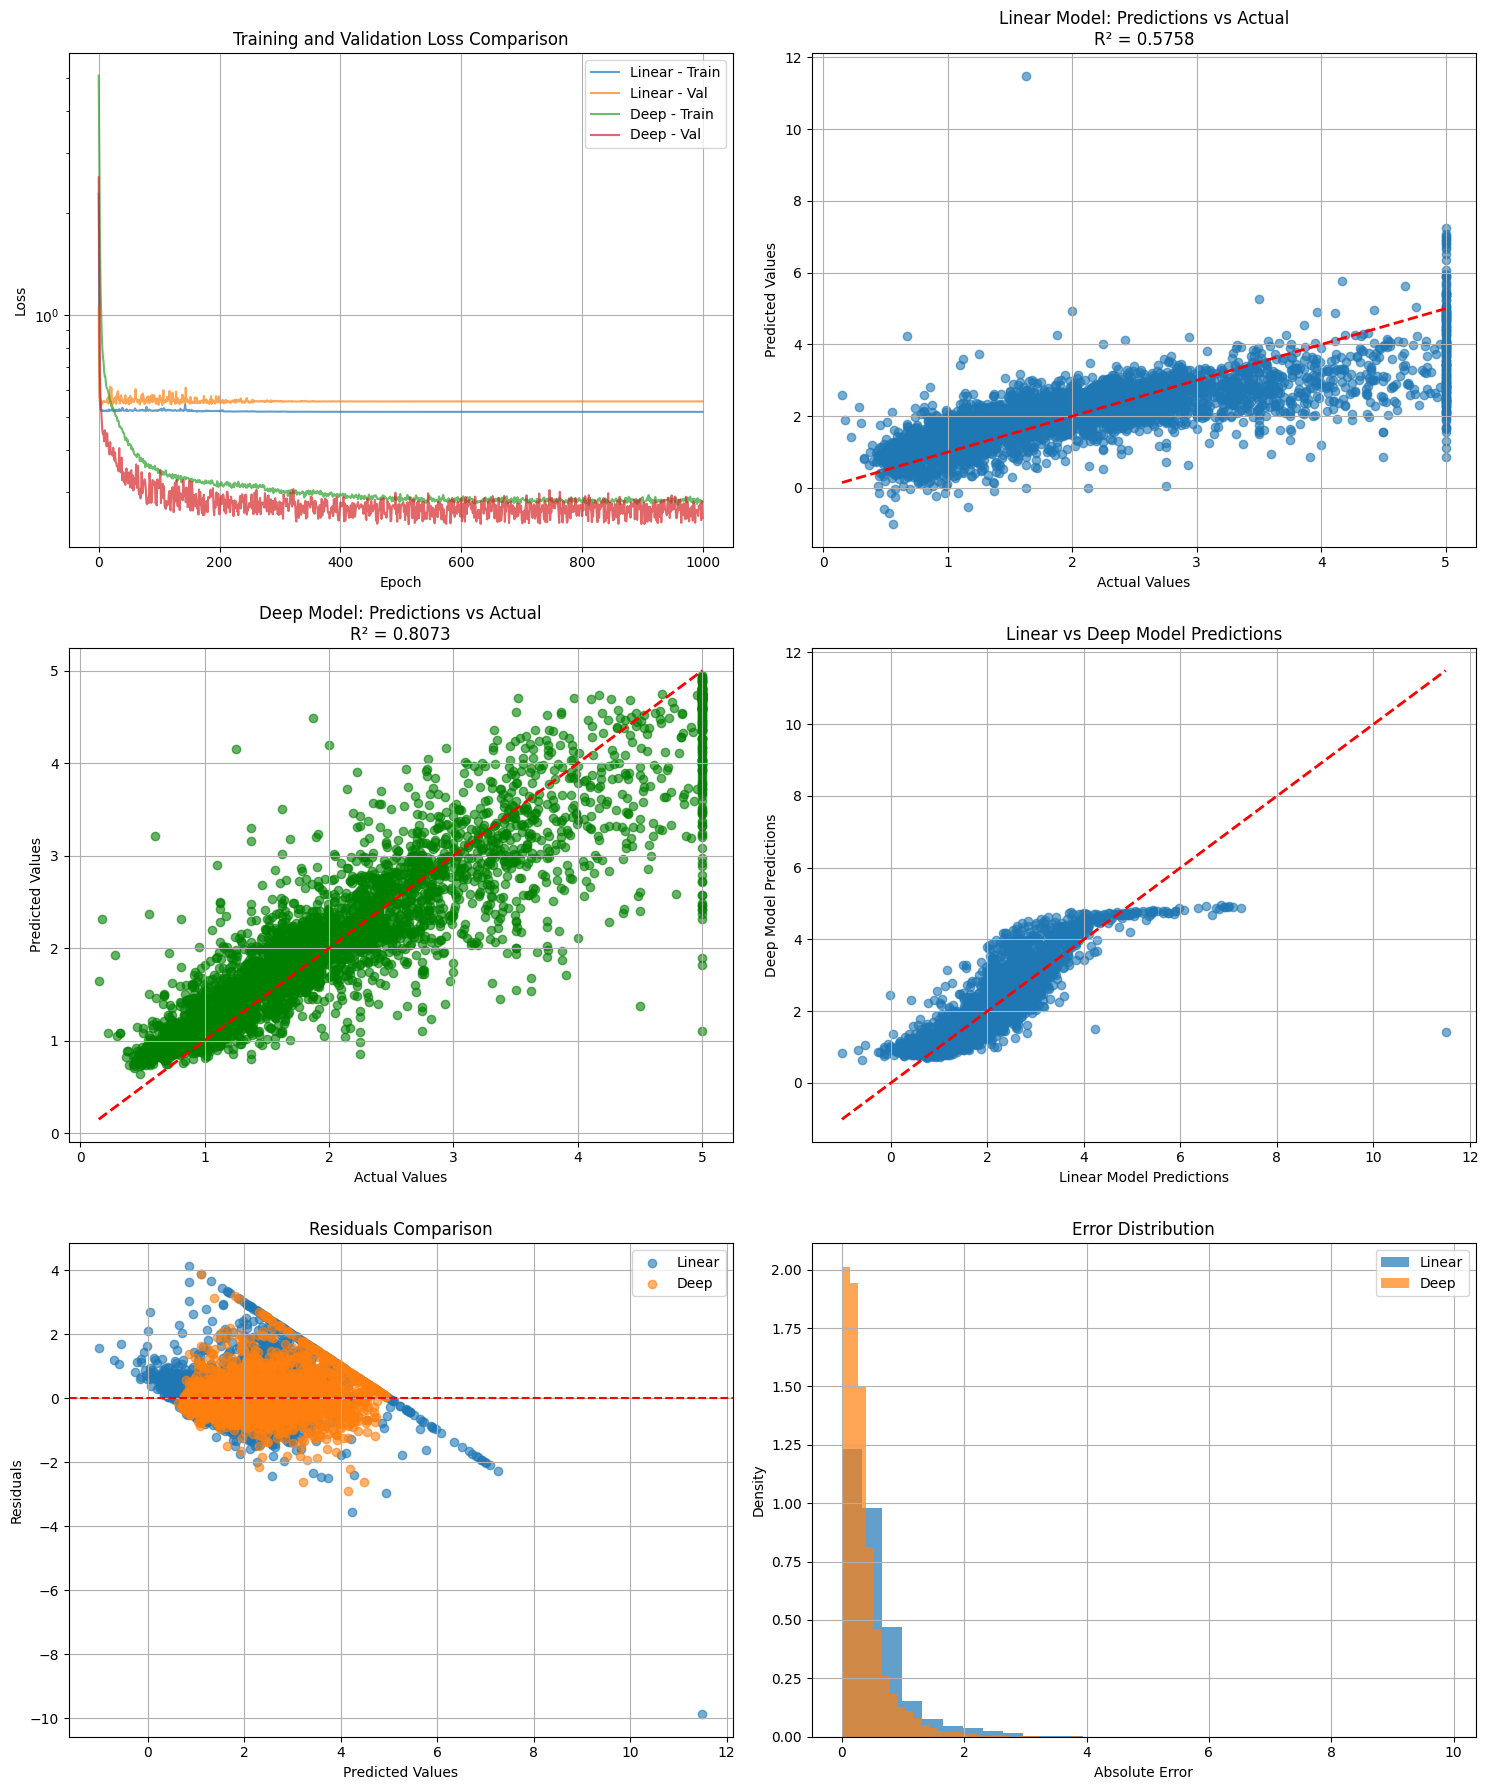


Linear Model Feature Weights:
MedInc: 0.8544
HouseAge: 0.1226
AveRooms: -0.2944
AveBedrms: 0.3392
Population: -0.0023
AveOccup: -0.0410
Latitude: -0.8964
Longitude: -0.8693

Sample Predictions Comparison:
Sample   Actual     Linear     Deep       Linear Err   Deep Err  
-----------------------------------------------------------------
1        2.385      1.960      2.757      0.425        0.372     
2        3.297      2.667      2.100      0.630        1.197     
3        0.952      1.951      1.252      0.999        0.300     
4        2.451      2.527      2.660      0.076        0.209     
5        0.641      0.048      0.970      0.593        0.329     
6        3.766      3.145      2.989      0.621        0.777     
7        2.307      2.891      2.395      0.584        0.088     
8        1.752      2.051      1.860      0.299        0.108     
9        4.167      5.766      4.738      1.599        0.571     
10       0.938      1.183      0.978      0.245        0.040     


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import time

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

class DeepRegressionModel(nn.Module):
    def __init__(self, input_size, hidden_sizes=[128, 64, 32, 16], dropout_rate=0.2):
        super(DeepRegressionModel, self).__init__()
        
        layers = []
        prev_size = input_size
        
        # Hidden layers
        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.ReLU(),
                nn.BatchNorm1d(hidden_size),
                nn.Dropout(dropout_rate)
            ])
            prev_size = hidden_size
        
        # Output layer
        layers.append(nn.Linear(prev_size, 1))
        
        self.network = nn.Sequential(*layers)
        
        # Initialize weights
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.kaiming_uniform_(module.weight, nonlinearity='relu')
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)
    
    def forward(self, x):
        return self.network(x)

class SimpleLinearModel(nn.Module):
    """For comparison with the linear model"""
    def __init__(self, input_size):
        super(SimpleLinearModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)
    
    def forward(self, x):
        return self.linear(x)

def train_model(model, X_train, y_train, X_test, y_test, num_epochs=1000, lr=0.001, batch_size=128):
    """Training function with batch processing"""
    
    # Create data loaders
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=50, factor=0.5)
    
    train_losses = []
    val_losses = []
    
    print(f"Training {model.__class__.__name__}...")
    start_time = time.time()
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        # Validation phase
        model.eval()
        with torch.no_grad():
            val_pred = model(X_test)
            val_loss = criterion(val_pred, y_test).item()
        
        scheduler.step(val_loss)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        if (epoch + 1) % 100 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, '
                  f'Val Loss: {val_loss:.4f}, LR: {current_lr:.6f}')
    
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
    
    return train_losses, val_losses

def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """Evaluate model performance"""
    model.eval()
    with torch.no_grad():
        train_pred = model(X_train).numpy()
        test_pred = model(X_test).numpy()
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
    train_r2 = r2_score(y_train, train_pred)
    test_r2 = r2_score(y_test, test_pred)
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"\n{model_name} Results:")
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Train RMSE: {train_rmse:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")
    print(f"Train R²: {train_r2:.4f}")
    print(f"Test R²: {test_r2:.4f}")
    
    return {
        'train_rmse': train_rmse, 'test_rmse': test_rmse,
        'train_r2': train_r2, 'test_r2': test_r2,
        'train_pred': train_pred, 'test_pred': test_pred,
        'total_params': total_params
    }

# Load and prepare data
print("Loading California Housing dataset...")
data = fetch_california_housing()
X, y = data.data, data.target

print(f"Dataset shape: {X.shape}")
print(f"Target range: ${y.min():.1f}00k - ${y.max():.1f}00k")

# Split and scale data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test).reshape(-1, 1)

input_size = X_train_tensor.shape[1]

# Create models
linear_model = SimpleLinearModel(input_size)
deep_model = DeepRegressionModel(input_size, hidden_sizes=[128, 64, 32, 16], dropout_rate=0.3)

# Train linear model
print("\n" + "="*50)
linear_train_losses, linear_val_losses = train_model(
    linear_model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor,
    num_epochs=1000, lr=0.01, batch_size=128
)

# Train deep model
print("\n" + "="*50)
deep_train_losses, deep_val_losses = train_model(
    deep_model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor,
    num_epochs=1000, lr=0.001, batch_size=128
)

# Evaluate both models
print("\n" + "="*50)
linear_results = evaluate_model(linear_model, X_train_tensor, y_train_tensor, 
                               X_test_tensor, y_test_tensor, "Linear Model")

deep_results = evaluate_model(deep_model, X_train_tensor, y_train_tensor, 
                             X_test_tensor, y_test_tensor, "Deep Neural Network")

# Model comparison
print("\n" + "="*50)
print("MODEL COMPARISON:")
print(f"Linear Model - Test R²: {linear_results['test_r2']:.4f}, Parameters: {linear_results['total_params']:,}")
print(f"Deep Model   - Test R²: {deep_results['test_r2']:.4f}, Parameters: {deep_results['total_params']:,}")
print(f"Improvement: {((deep_results['test_r2'] - linear_results['test_r2']) / linear_results['test_r2'] * 100):.1f}%")

# Comprehensive plotting
fig, axes = plt.subplots(3, 2, figsize=(15, 18))

# Plot 1: Training losses comparison
axes[0, 0].plot(linear_train_losses, label='Linear - Train', alpha=0.7)
axes[0, 0].plot(linear_val_losses, label='Linear - Val', alpha=0.7)
axes[0, 0].plot(deep_train_losses, label='Deep - Train', alpha=0.7)
axes[0, 0].plot(deep_val_losses, label='Deep - Val', alpha=0.7)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss Comparison')
axes[0, 0].legend()
axes[0, 0].grid(True)
axes[0, 0].set_yscale('log')

# Plot 2: Predictions vs Actual - Linear Model
axes[0, 1].scatter(y_test, linear_results['test_pred'], alpha=0.6, label='Linear')
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual Values')
axes[0, 1].set_ylabel('Predicted Values')
axes[0, 1].set_title(f'Linear Model: Predictions vs Actual\nR² = {linear_results["test_r2"]:.4f}')
axes[0, 1].grid(True)

# Plot 3: Predictions vs Actual - Deep Model
axes[1, 0].scatter(y_test, deep_results['test_pred'], alpha=0.6, color='green', label='Deep')
axes[1, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1, 0].set_xlabel('Actual Values')
axes[1, 0].set_ylabel('Predicted Values')
axes[1, 0].set_title(f'Deep Model: Predictions vs Actual\nR² = {deep_results["test_r2"]:.4f}')
axes[1, 0].grid(True)

# Plot 4: Both predictions comparison
axes[1, 1].scatter(linear_results['test_pred'], deep_results['test_pred'], alpha=0.6)
min_pred = min(linear_results['test_pred'].min(), deep_results['test_pred'].min())
max_pred = max(linear_results['test_pred'].max(), deep_results['test_pred'].max())
axes[1, 1].plot([min_pred, max_pred], [min_pred, max_pred], 'r--', lw=2)
axes[1, 1].set_xlabel('Linear Model Predictions')
axes[1, 1].set_ylabel('Deep Model Predictions')
axes[1, 1].set_title('Linear vs Deep Model Predictions')
axes[1, 1].grid(True)

# Plot 5: Residuals comparison
linear_residuals = y_test - linear_results['test_pred'].flatten()
deep_residuals = y_test - deep_results['test_pred'].flatten()

axes[2, 0].scatter(linear_results['test_pred'], linear_residuals, alpha=0.6, label='Linear')
axes[2, 0].scatter(deep_results['test_pred'], deep_residuals, alpha=0.6, label='Deep')
axes[2, 0].axhline(y=0, color='r', linestyle='--')
axes[2, 0].set_xlabel('Predicted Values')
axes[2, 0].set_ylabel('Residuals')
axes[2, 0].set_title('Residuals Comparison')
axes[2, 0].legend()
axes[2, 0].grid(True)

# Plot 6: Error distribution
axes[2, 1].hist(np.abs(linear_residuals), bins=30, alpha=0.7, label='Linear', density=True)
axes[2, 1].hist(np.abs(deep_residuals), bins=30, alpha=0.7, label='Deep', density=True)
axes[2, 1].set_xlabel('Absolute Error')
axes[2, 1].set_ylabel('Density')
axes[2, 1].set_title('Error Distribution')
axes[2, 1].legend()
axes[2, 1].grid(True)

plt.tight_layout()
plt.show()

# Feature analysis for linear model (for comparison)
if hasattr(linear_model, 'linear'):
    weights = linear_model.linear.weight.detach().numpy().flatten()
    feature_names = data.feature_names
    
    print(f"\nLinear Model Feature Weights:")
    for feature, weight in zip(feature_names, weights):
        print(f"{feature}: {weight:.4f}")

# Sample predictions comparison
print(f"\nSample Predictions Comparison:")
print(f"{'Sample':<8} {'Actual':<10} {'Linear':<10} {'Deep':<10} {'Linear Err':<12} {'Deep Err':<10}")
print("-" * 65)

sample_indices = np.random.choice(len(X_test), 10, replace=False)
with torch.no_grad():
    for i, idx in enumerate(sample_indices):
        actual = y_test[idx]
        linear_pred = linear_model(X_test_tensor[idx:idx+1]).item()
        deep_pred = deep_model(X_test_tensor[idx:idx+1]).item()
        linear_err = abs(actual - linear_pred)
        deep_err = abs(actual - deep_pred)
        
        print(f"{i+1:<8} {actual:<10.3f} {linear_pred:<10.3f} {deep_pred:<10.3f} "
              f"{linear_err:<12.3f} {deep_err:<10.3f}")